### NOTE: This has code which is not definitive and was used as an experimental notebook. Do not use it to generate predictions!

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import sys
sys.path.append("../")

from src.training_utils.training import load_model
from src.line_detection.hough import *
from ast import literal_eval
from src.ocr_utils.ocr import *
from src.slides_utils.slides_utils import slice_img_from_prediction

2023-02-15 18:48:39.183484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 18:48:41.571051: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-02-15 18:48:41.572091: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packag

In [3]:
import os
import cv2
import torch
import spacy
import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image
from torchvision import transforms as T
import torchvision
from paddleocr import PaddleOCR

2023-02-14 20:26:32.592276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 20:26:35.244945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-02-14 20:26:35.246252: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packag

In [4]:
PATH_MODELS = "/home/nacho/TFI-Cazcarra/data/models"
PATH_YOLO = "/home/nacho/TFI-Cazcarra/yolov3/runs/train"

## Realizo predicciones

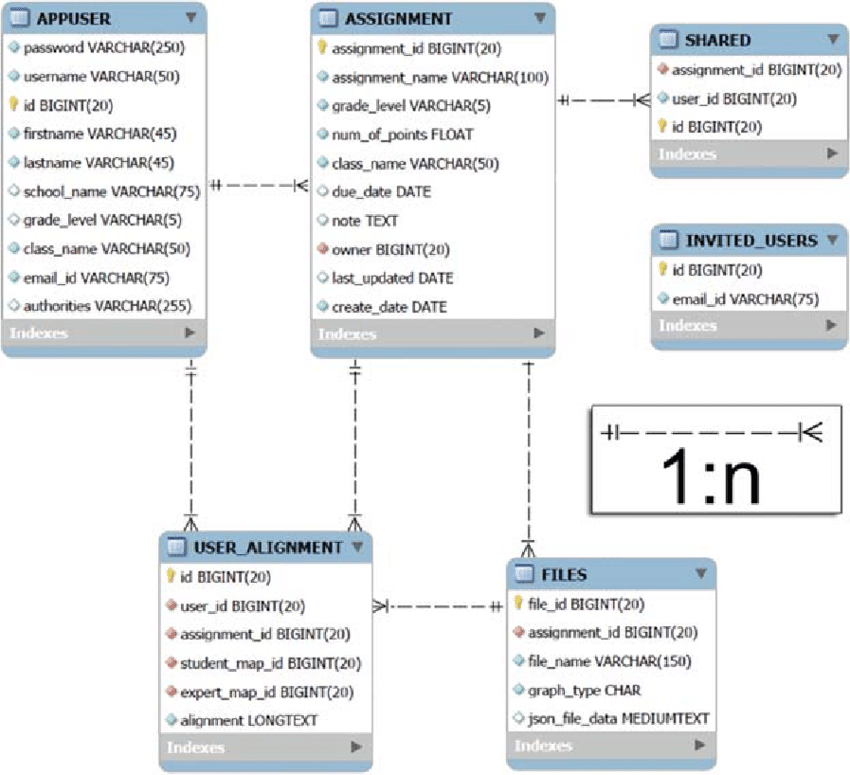

In [49]:
img_path = '/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-9.png'
img = Image.open(img_path).convert("RGB")

min_size = 600
max_size = 1333

transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
# img_tensor = torchvision.models.detection.transform._resize_image_and_masks(img_tensor, self_max_size=max_size,
#                                                                               self_min_size=min_size)[0]
# img = Image.fromarray(img_tensor.numpy())
# print(img_tensor.shape)
img

In [12]:
def draw_bbox(img, xmin, ymin, xmax, ymax): 
    return cv2.rectangle(img, (xmin, ymin), (xmax, ymax), 
                         (255,0,0), 1)

def visualize_boxes(img, boxes):
    img = np.array(img)
    for b in boxes:
        xmin = b[0]
        ymin = b[1]
        xmax = b[2]
        ymax = b[3]
        img = draw_bbox(img, xmin, ymin, xmax, ymax)
    return Image.fromarray(img)

### 1. Extraigo las tablas

In [7]:
retinanet_tablas = load_model(os.path.join(PATH_MODELS, "model_best_tablas_retinanet.pt"))
faster_rcnn_tablas = load_model(os.path.join(PATH_MODELS, "model_best_tablas_fasterrcnn.pt"))

In [8]:
yolo_tablas = torch.hub.load('ultralytics/yolov5', 'custom', \
                             os.path.join(PATH_YOLO, "exp5", "weights", "best_tablas.pt"))

Using cache found in /home/nacho/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-8 Python-3.8.10 torch-1.13.0+cu117 CPU

Fusing layers... 
Model summary: 261 layers, 61497430 parameters, 0 gradients, 154.5 GFLOPs
Adding AutoShape... 


In [9]:
def filter_predictions(predictions, score_threshold=0.5, nms_threshold=0.5):
    boxes = predictions['boxes'][predictions['scores'] >= score_threshold]
    scores = predictions['scores'][predictions['scores'] >= score_threshold]
    valid_idx = torchvision.ops.nms(boxes, scores, nms_threshold)
    return boxes[valid_idx], scores[valid_idx]

In [28]:
tablas_1 = retinanet_tablas([img_tensor])[1][0]
boxes_1, scores_1 = filter_predictions(tablas_1, nms_threshold=0.5)

In [31]:
tablas_2 = faster_rcnn_tablas([img_tensor])[1][0]
boxes_2, scores_2 = filter_predictions(tablas_2)

In [47]:
tablas_3 = yolo_tablas(img)
tablas_3 = {"boxes": tablas_3.xyxy[0][:, :4], "scores": tablas_3.xyxy[0][:, 4]}
boxes_3, scores_3 = filter_predictions(tablas_3)

### 2. Extraigo las cardinalidades

In [ ]:
def unify_images(img, boxes_per_tile):
    img = np.array(img)
    first_tile = next(iter(boxes_per_tile.keys()))
    all_boxes = np.array([[]])
    all_scores = np.array([])
    
    for tile, prediction in boxes_per_tile.items():
        coords_to_add = torch.Tensor(list(map(lambda i,j: i-j, literal_eval(tile), literal_eval(first_tile))))
        boxes = torch.add(prediction['boxes'], coords_to_add, alpha=1).detach().numpy()
        all_boxes = np.append(all_boxes, boxes)
        all_scores = np.append(all_scores, prediction['scores'])
    return {"boxes": torch.from_numpy(all_boxes.reshape((-1,4))), "scores": torch.from_numpy(all_scores)}


def predict_tiles(img, model, is_yolo, min_size=600, max_size=1333):
    tiles = slice_img_from_prediction(img, tile_size=None, tile_overlap=0.0, number_tiles=6)
    
    preds_image = {}
    with torch.no_grad():
        for tile in tiles:
            tile_img = img.crop(tile).convert("RGB")
            tensor_tile = transform(tile_img)
#             tensor_tile = torchvision.models.detection.transform._resize_image_and_masks(img_tensor, 
#                                                                               self_max_size=max_size,
#                                                                               self_min_size=min_size)[0]
            if not is_yolo:
                predictions = model([tensor_tile])[1][0]
            else:
                predictions = model(tile_img)
                predictions = {"boxes": predictions.xyxyn[0][:, :4], "scores": predictions.xyxyn[0][:, 4]}
            preds_image[str(tile)] = predictions
    unified_results = unify_images(img=img, boxes_per_tile=preds_image)
    boxes, scores = filter_predictions(unified_results, nms_threshold=0.1)
    return boxes, scores

In [ ]:
retinanet_cardinalidades = load_model(os.path.join(PATH_MODELS, "model_best_cardinalidades_retinanet.pt"))
faster_rcnn_cardinalidades = load_model(os.path.join(PATH_MODELS, "model_best_cardinalidades_fasterrcnn.pt"))

yolo_cardinalidades = torch.hub.load('ultralytics/yolov5', 'custom', \
                             os.path.join(PATH_YOLO, "exp3", "weights", "best_cardinalidades.pt"))

In [ ]:
boxes_c1, scores_c1 = predict_tiles(img, retinanet_cardinalidades, False)
boxes_c2, scores_c2 = predict_tiles(img, faster_rcnn_cardinalidades, False)
boxes_c3, scores_c3 = predict_tiles(img, yolo_cardinalidades, True)

## Encuentro las líneas y junto con las cardinalidades

In [ ]:
OFFSET_TABLAS = 5

In [ ]:
def clean_cardinalidades(cardinalidades, tablas, distance_threshold=30):
    # Si tiene una tabla a menos de X puntos de distancia..
    return [c for c in cardinalidades if nearest_tabla_from_cardinalidad(c, tablas, \
                                                                         distance_threshold=distance_threshold)]

In [ ]:
def find_lines(img_path, tablas, cardinalidades):
    img_basename = os.path.basename(img_path)
    ## ESTOY USANDO LAS QUE YA ESTÁN CARGADAS
    # tablas, cardinalidades = get_tablas(img_basename)
    # Agrandamos un toque las cajas
    offset = np.array([-OFFSET_TABLAS, -OFFSET_TABLAS, OFFSET_TABLAS, OFFSET_TABLAS]).reshape(1,4)
    tablas = np.sum([tablas, offset])

    img, all_lines = apply_hough(img_path, tablas, [])

    all_points = lines_to_points(all_lines)
    lines = hough_detecting(all_points)

    cardinalidades = clean_cardinalidades(cardinalidades, tablas)
    
    return unify_cardinalidades(img, lines, cardinalidades)

In [ ]:
def line_to_points(x, y, max_dst_per_points=2):
    dst_line = math.dist(x,y)
    parts = dst_line // max_dst_per_points
    return np.linspace(x, y, int(parts)+1).tolist()


def dist_func(comb):
    return math.dist(comb[0], comb[1])


def get_centroid(cardinalidad):
    center_x  = cardinalidad[0] + (cardinalidad[2] - cardinalidad[0])/2
    center_y  = cardinalidad[1] + (cardinalidad[3] - cardinalidad[1])/2
    return (center_x, center_y)


def nearest_tabla_from_cardinalidad(cardinalidad, tablas, distance_threshold=999999):
    cardinalidad = literal_eval(cardinalidad) if isinstance(cardinalidad, str) else cardinalidad
    cardinalidad_centroid = get_centroid(cardinalidad)
    dict_dist_tablas = {}
    for t in tablas:
        tabla_points = []
        # De x1y1 a x2y1
        tabla_points += line_to_points((t[0], t[1]), (t[2], t[1]))
        # De x1y1 a x1y2
        tabla_points += line_to_points((t[0], t[1]), (t[0], t[3]))
        # De x1y2 a x2y2
        tabla_points += line_to_points((t[0], t[3]), (t[2], t[3]))
        # De x2y1 a x2y2
        tabla_points += line_to_points((t[2], t[1]), (t[2], t[3]))
        dist_cardinalidad = [(cardinalidad_centroid, point) for point in tabla_points]
        min_combination = min(dist_cardinalidad, key=dist_func)
        dict_dist_tablas[",".join([str(c) for c in t])] = dist_func(min_combination)
    nearest_tabla = min(dict_dist_tablas, key=dict_dist_tablas.get)
    
    if min(dict_dist_tablas.values()) >= distance_threshold:
        return [] 
    return [int(c) for c in nearest_tabla.split(",")]

In [ ]:
pairs = []

img_basename = os.path.basename(img_path)
# tablas, _ = get_tablas(img_basename)
tablas = boxes_1.detach().numpy().astype(int)

for line_name, line in find_lines(img_path, tablas=tablas, 
                                  cardinalidades=boxes_c1.detach().numpy().astype(int)).items():
    cardinalidades = line.split("|")
    tabla_a = nearest_tabla_from_cardinalidad(cardinalidades[0], tablas)
    tabla_b = nearest_tabla_from_cardinalidad(cardinalidades[1], tablas)
    pairs.append((tabla_a, tabla_b))

In [ ]:
pairs

## OCR

In [ ]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download es_core_news_sm

In [ ]:
# TODO: Choose algo and language.
DET_ALGO = "db" # or "east"
REC_ALGO = "svtr" # or "crnn"
LANG = "en"

if LANG == "es":
    nlp_spanish = spacy.load("es_core_news_sm")
else:
    nlp_english = spacy.load("en_core_web_sm")

ocr = PaddleOCR(use_angle_cls=False, lang=LANG, show_log=False, 
                det_algorithm_dir=f"/home/nacho/TFI-Cazcarra/ocr/{DET_ALGO}/", 
                rec_algorithm_dir=f"/home/nacho/TFI-Cazcarra/ocr/{REC_ALGO}/", det_db_score_mode="slow") 

In [ ]:
def predict_ocr(img, tablas, ocr_model):
    coords = []
    results = []
    img_arr = img if isinstance(np.array([]), np.ndarray) else np.array(img)

    for t in tablas:
        tabla_cropped = img_arr[t[1]:t[3], t[0]:t[2]]
        tabla_cropped = reescale(tabla_cropped)
        if len(tabla_cropped.shape) == 3 and tabla_cropped.shape[-1] > 3:
            tabla_cropped = tabla_cropped[:,:,:3]
        result = ocr_model.ocr(tabla_cropped, cls=False)

        coords.append(t.tolist())
        results.append(result[0])
    return coords, results

In [ ]:
def extract_from_ocr(coords, results):
    all_tables = {}
    tables_names = {}
    for c, r in zip(coords, results):
        boxes = [line[0] for line in r]
        txts = [line[1][0].strip() for line in r]
        scores = [line[1][1] for line in r]
        table, dict_attributes = clean_texts(txts)
        all_tables[table] = dict_attributes
        tables_names[table] = c
    return all_tables, tables_names

In [ ]:
def pairs_to_names(pairs, tables_names):
    new_pairs = []
    tables_names = {str(v):k for k,v in tables_names.items()}
    
    for pair in pairs:
        tabla_a, tabla_b = pair
        tabla_a, tabla_b = tables_names[str(tabla_a)], tables_names[str(tabla_b)]
        new_pairs.append((tabla_a, tabla_b))
    return new_pairs

In [ ]:
def extract_candidate_keys(table_attributes):
    return [attr for attr in table_attributes if "_id" in attr]

In [ ]:
def get_primary_keys(candidates, fks):
    '''
    Remueve los candidatos ya elegidos
    '''
    return list(set(candidates) - set(fks))

def get_foreign_keys(table, candidates, pairs, lemmatizer=nlp_english):
    def is_foreign_key(table_pair, candidates, table, lemmatizer):
        '''
        Se fija si hay un match entre un atributo con _id en su versión original y lematizada.
        Ejemplo: poem_id con la tabla poems -> buscaria match con poems_id o poem_id.
        '''
        pair = table_pair + "_id"
        
        table_pair_lemmatized = lemmatizer(table_pair)[0].lemma_
        pair_lemmatized = table_pair_lemmatized + "_id"
        
        table_match = (table_pair == table or table_pair_lemmatized == table)
        
        pair_match = (pair in candidates and not table_match)
        pair_lemmatized_match = (pair_lemmatized in candidates and not table_match)
                
        if pair_match:
            return True, pair
        elif pair_lemmatized_match:
            return True, pair_lemmatized
        else:
            return False, ""
    """
    Ejemplo:
    table -> poems
    candidates -> ['poems_id', 'users_id', 'categories_id']
    pairs -> [('tokens', 'users'), ('poems', 'users'), ('poems', 'categories')]
    """
    fks = {}
    for pair in pairs:
        if table not in pair:
            continue
        is_fk_pair0, p0 = is_foreign_key(table_pair=pair[0], candidates=candidates, \
                                         table=table, lemmatizer=lemmatizer)
        is_fk_pair1, p1 = is_foreign_key(table_pair=pair[1], candidates=candidates, \
                                         table=table, lemmatizer=lemmatizer)
        if is_fk_pair0:
            fks[p0] = pair[0]
        elif is_fk_pair1:
            fks[p1] = pair[1]
    return fks


def generate_pks_code(pks):
    keys = pks.keys()
    keys = ", ".join(keys)
    return f"PRIMARY KEY ({keys})"


def generate_fks_code(table, fks):
    code = ""
    for fk, table_reference in fks.items():
        code += f"ALTER TABLE {table} ADD FOREIGN KEY ({fk}) REFERENCES {table_reference}({fk}); \n"
    return code


def create_code(table, dict_attributes, primary_keys, foreign_keys):
    '''
    Crea una tabla de MySQL
    '''
    attributes_code = "  "
    i = 0
    for k, v in dict_attributes.items():
        attributes_code += k + " " + v           
        attributes_code += ",\n   "
        i += 1
    pks_code = generate_pks_code(primary_keys)
    fks_code = generate_fks_code(table, foreign_keys)
    if pks_code:
        attributes_code += pks_code
    code = f" CREATE TABLE {table} ( \n {attributes_code} \n ); \n"
    return code, fks_code


def generate_db():
    all_code = ""
    all_fks_code = ""
    pairs = pairs_to_names(pairs, tables_names)
    for k, dict_attributes in all_tables.items():
        candidates = extract_candidate_keys(all_tables[k].keys())
        fks = get_foreign_keys(table=k, candidates=candidates, pairs=pairs)
        pks = {pk: k for pk in get_primary_keys(candidates, fks.keys())}
        code, fk_code = create_code(k, dict_attributes, pks, fks)
        all_code += code
        all_fks_code += fk_code

    return all_code + "\n" + all_fks_code

In [ ]:
# coords = []
# results = []

# img_arr = np.array(img)

# for t in tablas:
#     tabla_cropped = img_arr[t[1]:t[3], t[0]:t[2]]
#     tabla_cropped = reescale(tabla_cropped)
#     if len(tabla_cropped.shape) == 3 and tabla_cropped.shape[-1] > 3:
#         tabla_cropped = tabla_cropped[:,:,:3]
#     result = ocr.ocr(tabla_cropped, cls=False)
    
#     coords.append(t.tolist())
#     results.append(result[0])

In [ ]:
# all_tables = {}
# tables_names = {}

# for c, r in zip(coords, results):
#     boxes = [line[0] for line in r]
#     txts = [line[1][0].strip() for line in r]
#     scores = [line[1][1] for line in r]
#     table, dict_attributes = clean_texts(txts)
#     all_tables[table] = dict_attributes
#     tables_names[table] = c

In [ ]:
# def pairs_to_names(pairs, tables_names):
#     new_pairs = []
#     tables_names = {str(v):k for k,v in tables_names.items()}
    
#     for pair in pairs:
#         tabla_a, tabla_b = pair
#         tabla_a, tabla_b = tables_names[str(tabla_a)], tables_names[str(tabla_b)]
#         new_pairs.append((tabla_a, tabla_b))
#     return new_pairs

In [ ]:
pairs = pairs_to_names(pairs, tables_names)

In [ ]:
# def extract_candidate_keys(table_attributes):
#     return [attr for attr in table_attributes if "_id" in attr]

In [ ]:
# def get_primary_keys(candidates, fks):
#     '''
#     Remueve los candidatos ya elegidos
#     '''
#     return list(set(candidates) - set(fks))

# def get_foreign_keys(table, candidates, pairs, lemmatizer=nlp_english):
#     def is_foreign_key(table_pair, candidates, table, lemmatizer):
#         '''
#         Se fija si hay un match entre un atributo con _id en su versión original y lematizada.
#         Ejemplo: poem_id con la tabla poems -> buscaria match con poems_id o poem_id.
#         '''
#         pair = table_pair + "_id"
        
#         table_pair_lemmatized = lemmatizer(table_pair)[0].lemma_
#         pair_lemmatized = table_pair_lemmatized + "_id"
        
#         table_match = (table_pair == table or table_pair_lemmatized == table)
        
#         pair_match = (pair in candidates and not table_match)
#         pair_lemmatized_match = (pair_lemmatized in candidates and not table_match)
                
#         if pair_match:
#             return True, pair
#         elif pair_lemmatized_match:
#             return True, pair_lemmatized
#         else:
#             return False, ""
#     """
#     Ejemplo:
#     table -> poems
#     candidates -> ['poems_id', 'users_id', 'categories_id']
#     pairs -> [('tokens', 'users'), ('poems', 'users'), ('poems', 'categories')]
#     """
#     fks = {}
#     for pair in pairs:
#         if table not in pair:
#             continue
#         is_fk_pair0, p0 = is_foreign_key(table_pair=pair[0], candidates=candidates, \
#                                          table=table, lemmatizer=lemmatizer)
#         is_fk_pair1, p1 = is_foreign_key(table_pair=pair[1], candidates=candidates, \
#                                          table=table, lemmatizer=lemmatizer)
#         if is_fk_pair0:
#             fks[p0] = pair[0]
#         elif is_fk_pair1:
#             fks[p1] = pair[1]
#     return fks

In [ ]:
pairs = pairs_to_names(pairs, tables_names)

In [ ]:
# pairs = pairs_to_names(pairs, tables_names)

# for k in all_tables.keys():  
#     candidates = extract_candidate_keys(all_tables[k].keys())
#     fks = get_foreign_keys(table=k, candidates=candidates, pairs=pairs)
#     pks = {pk: k for pk in get_primary_keys(candidates, fks.keys())}
#     print(f"Table: {k}")
#     print(f"Candidates: {candidates}")
#     print(f"FKS: {fks}")
#     print(f"PKS: {pks}")
#     print("####################")

In [ ]:
# def generate_pks_code(pks):
#     keys = pks.keys()
#     keys = ", ".join(keys)
#     return f"PRIMARY KEY ({keys})"


# def generate_fks_code(table, fks):
#     code = ""
#     for fk, table_reference in fks.items():
#         code += f"ALTER TABLE {table} ADD FOREIGN KEY ({fk}) REFERENCES {table_reference}({fk}); \n"
#     return code


# def create_code(table, dict_attributes, primary_keys, foreign_keys):
#     '''
#     Crea una tabla de MySQL
#     '''
#     attributes_code = "  "
#     i = 0
#     for k, v in dict_attributes.items():
#         attributes_code += k + " " + v           
#         attributes_code += ",\n   "
#         i += 1
#     pks_code = generate_pks_code(primary_keys)
#     fks_code = generate_fks_code(table, foreign_keys)
#     if pks_code:
#         attributes_code += pks_code
#     code = f" CREATE TABLE {table} ( \n {attributes_code} \n ); \n"
#     return code, fks_code


# def generate_db():
#     all_code = ""
#     all_fks_code = ""
#     pairs = pairs_to_names(pairs, tables_names)
#     for k, dict_attributes in all_tables.items():
#         candidates = extract_candidate_keys(all_tables[k].keys())
#         fks = get_foreign_keys(table=k, candidates=candidates, pairs=pairs)
#         pks = {pk: k for pk in get_primary_keys(candidates, fks.keys())}
#         code, fk_code = create_code(k, dict_attributes, pks, fks)
#         all_code += code
#         all_fks_code += fk_code

#     return all_code + "\n" + all_fks_code

In [ ]:
# def create_code(table, dict_attributes, primary_keys, foreign_keys):
#     '''
#     Crea una tabla de MySQL
#     '''
#     attributes_code = "  "
#     i = 0
#     for k, v in dict_attributes.items():
#         attributes_code += k + " " + v           
#         attributes_code += ",\n   "
#         i += 1
#     pks_code = generate_pks_code(primary_keys)
#     fks_code = generate_fks_code(table, foreign_keys)
#     if pks_code:
#         attributes_code += pks_code
#     code = f" CREATE TABLE {table} ( \n {attributes_code} \n ); \n"
#     return code, fks_code


# def generate_db():
#     all_code = ""
#     all_fks_code = ""
#     pairs = pairs_to_names(pairs, tables_names)
#     for k, dict_attributes in all_tables.items():
#         candidates = extract_candidate_keys(all_tables[k].keys())
#         fks = get_foreign_keys(table=k, candidates=candidates, pairs=pairs)
#         pks = {pk: k for pk in get_primary_keys(candidates, fks.keys())}
#         code, fk_code = create_code(k, dict_attributes, pks, fks)
#         all_code += code
#         all_fks_code += fk_code

#     return all_code + "\n" + all_fks_code

In [ ]:
# def generate_db():
#     all_code = ""
#     all_fks_code = ""
#     pairs = pairs_to_names(pairs, tables_names)
#     for k, dict_attributes in all_tables.items():
#         candidates = extract_candidate_keys(all_tables[k].keys())
#         fks = get_foreign_keys(table=k, candidates=candidates, pairs=pairs)
#         pks = {pk: k for pk in get_primary_keys(candidates, fks.keys())}
#         code, fk_code = create_code(k, dict_attributes, pks, fks)
#         all_code += code
#         all_fks_code += fk_code

#     return all_code + "\n" + all_fks_code

In [ ]:
# all_code = ""
# all_fks_code = ""
# for k, dict_attributes in all_tables.items():
#     candidates = extract_candidate_keys(all_tables[k].keys())
#     fks = get_foreign_keys(table=k, candidates=candidates, pairs=pairs)
#     pks = {pk: k for pk in get_primary_keys(candidates, fks.keys())}
#     code, fk_code = create_code(k, dict_attributes, pks, fks)
#     all_code += code
#     all_fks_code += fk_code
    
# print(all_code + "\n" + all_fks_code)

## Una vez que está todo hecho, unificar acá y detectar puntos de mejora.